In [1]:
# -*- coding: utf-8 -*-

"""
This software is part of GPU Ocean. 
Copyright (C) 2019 SINTEF Digital

This python program is used to set up and run a data-assimilation 
and drift trajectory forecasting experiment.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
"""

from importlib import reload  

import sys, os


current_dir = os.getcwd()

if os.path.isdir(os.path.abspath(os.path.join(current_dir, '../../SWESimulators'))):
        sys.path.insert(0, os.path.abspath(os.path.join(current_dir, '../../')))

In [2]:

### ----------------------------------------------
#   FUNCTIONALITIES FOR PLOTTING
#

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

from matplotlib import pyplot as plt

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar

import matplotlib.cm as cm

        
def imshow3(eta, hu, hv, interpolation="None", title=None, figsize=(12.5,3.4), # (12.5, 3.4)
            color_bar_from_zero=False, save_filename=None, constant_range=False, pretitle='', max_eta=0.0, max_huv=0.0):
    
    fig, axs = plt.subplots(1,3, figsize=figsize)
    
    
    eta_max = np.max(np.abs(eta))
    huv_max = max(np.max(np.abs(hu)), np.max(np.abs(hv)))
    
    if constant_range:
        eta_max = 3.5
        huv_max = 625

    if max_eta > 0.0:
        eta_max = max_eta
    if max_huv > 0.0:
        huv_max = max_huv
    
    eta_cmap = 'BrBG'
    huv_cmap = 'RdBu'
    
    eta_min = -eta_max
    huv_min = -huv_max
    if color_bar_from_zero:
        eta_min, huv_min = 0, 0
        if constant_range:
            eta_max = 0.12
            huv_max = 50
        
        eta_cmap = 'BuGn'
        huv_cmap = 'Blues'
        
    
    fontsize = 18
    def addColorbar(ax, im, title):
        ax_divider = make_axes_locatable(ax)
        ax_cb = ax_divider.append_axes("top", size="10%", pad="5%")
        cbar = colorbar(im, cax=ax_cb, orientation="horizontal")
        ax_cb.xaxis.set_ticks_position("top")
        ax_cb.set_title(title, fontsize=fontsize)
    
    extent = None

    eta_im = axs[0].imshow(eta, interpolation=interpolation, origin='lower', 
                           vmin=eta_min, vmax=eta_max, extent=extent, cmap=eta_cmap) #GnBu')
    addColorbar(axs[0], eta_im, pretitle+"$\eta$ [m]")
    
    hu_im = axs[1].imshow(hu, interpolation=interpolation, origin='lower', 
                          vmin=huv_min, vmax=huv_max, extent=extent, cmap=huv_cmap)
    addColorbar(axs[1], hu_im, pretitle+"$hu$ [m$^2$/s]")
    
    
    hv_im = axs[2].imshow(hv, interpolation=interpolation, origin='lower',
                          vmin=huv_min, vmax=huv_max, extent=extent, cmap=huv_cmap)
    addColorbar(axs[2], hv_im, pretitle+"$hv$ [m$^2$/s]")
    
    axs[0].set_ylabel("...", labelpad=3, fontsize=fontsize)
    
    #for ax in axs:
    #    ax.set_xlabel("$x$ [km]")
    #    ax.set_ylabel("$y$ [km]")
    
    if title is not None:
        plt.suptitle(r"\textbf{"+title+"}", y=1.1) #, fontsize=14)
    #plt.tight_layout()
    


/home/florianb/miniconda3/envs/gpuocean/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.
  del sys.path[0]


In [3]:
# For GPU contex:
from SWESimulators import Common

# Create CUDA context
gpu_ctx = Common.CUDAContext()
device_name = gpu_ctx.cuda_device.name()

In [4]:
from SWESimulators import DoubleJetCase

doubleJetCase = DoubleJetCase.DoubleJetCase(gpu_ctx)
doubleJetCase_args, doubleJetCase_init = doubleJetCase.getInitConditions()

In [5]:
from SWESimulators import CDKLM16

sim = CDKLM16.CDKLM16(**doubleJetCase_args, **doubleJetCase_init, xorwow_seed=1)
sim.step(72*60*60)

259200.0

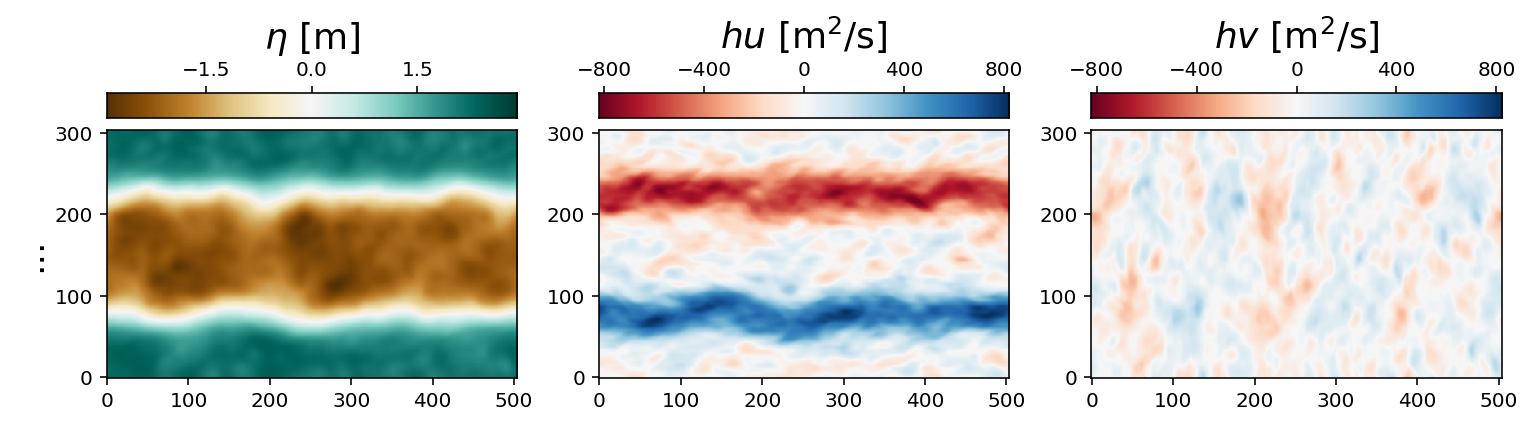

In [6]:
eta, hu, hv = sim.download()
imshow3(eta, hu, hv)

In [7]:
sim_check = CDKLM16.CDKLM16(**doubleJetCase_args, **doubleJetCase_init, use_lcg=True)
sim_check.step(72*60*60)


259200.0

In [8]:
eta_check, hu_check, hv_check = sim_check.download()
np.sum(eta == eta_check)

0

In [9]:
304*504

153216

In [10]:
randomState = np.random.RandomState()
randomState.seed(0)

In [11]:
randomState.rand(3,5)

array([[0.5488135 , 0.71518937, 0.60276338, 0.54488318, 0.4236548 ],
       [0.64589411, 0.43758721, 0.891773  , 0.96366276, 0.38344152],
       [0.79172504, 0.52889492, 0.56804456, 0.92559664, 0.07103606]])

In [12]:
from SWESimulators import OceanStateNoise
reload(OceanStateNoise)

smallScalePerturbation = OceanStateNoise.OceanStateNoise.fromsim(sim, use_lcg=True)

In [13]:
smallScalePerturbation.getSeed().shape

(300, 250)

In [14]:
smallScalePerturbation.getRandomNumbers()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [21]:
import pycuda
import pycuda.gpuarray
import pycuda.driver as cuda
from pycuda.curandom import seed_getter_uniform
from pycuda.curandom import XORWOWRandomNumberGenerator

def set_seeder(N, seed):
    seedarr = pycuda.gpuarray.ones_like(pycuda.gpuarray.zeros(N, dtype=np.int32), dtype=np.int32) * seed
    return seedarr

seed = 12346

rng = XORWOWRandomNumberGenerator( lambda N: set_seeder(N,seed) )

In [22]:
random_numbers_host = np.zeros((np.int32(3), np.int32(5)), dtype=np.float32, order='C')
random_numbers = Common.CUDAArray2D(sim.gpu_stream, np.int32(5.0), np.int32(3.0), 0, 0, random_numbers_host)

In [23]:
rng.fill_normal(random_numbers.data, stream=sim.gpu_stream)

In [24]:
random_numbers.download(sim.gpu_stream)


array([[ 0.65762734, -0.14282332,  0.7437423 ,  1.7834352 , -0.72807145],
       [-0.66283786,  0.28186005,  1.171512  , -0.58934057,  0.36001042],
       [ 0.67785364, -0.6896105 , -0.58363515, -0.87683636, -1.4626758 ]],
      dtype=float32)